In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load saved model bundle
bundle = joblib.load("final_churn_model.pkl")
model = bundle["model"]
threshold = bundle["threshold"]s

model


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",10.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not w

In [6]:
# Load data to get column names
df = pd.read_csv("telco_model_ready.csv")

X = df.drop(columns=["Churn"])
feature_names = X.columns


In [7]:
coefficients = model.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

coef_df = coef_df.sort_values(by="coefficient", ascending=False)
coef_df


,feature,coefficient
2,MonthlyCharges,0.832828
18,tenure_group_4-6yr,0.200162
8,fiber_optic,0.199751
13,MultipleLines_No phone service,0.166003
15,PaperlessBilling_Yes,0.146385
3,TotalCharges,0.126444
14,MultipleLines_Yes,0.119288
0,SeniorCitizen,0.087116
9,gender_Male,-0.003008
10,Partner_Yes,-0.012139


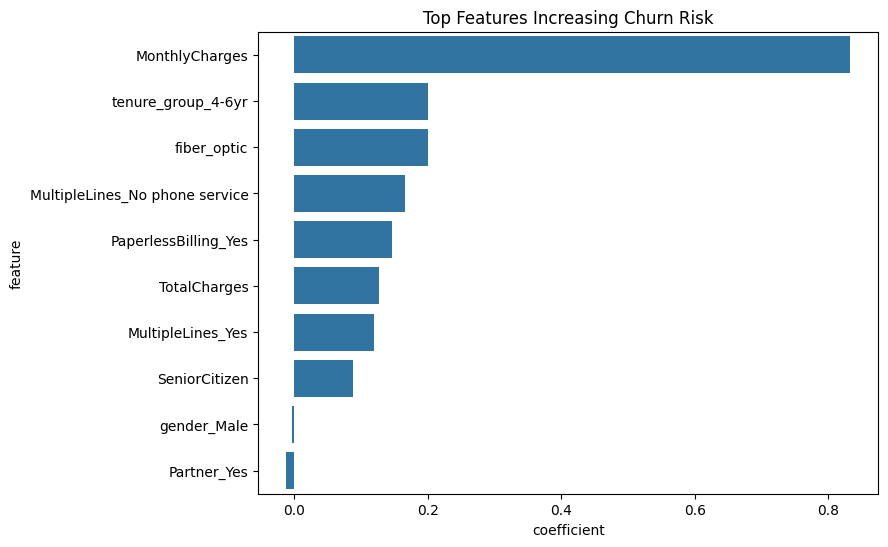

In [8]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="coefficient",
    y="feature",
    data=coef_df.head(10)
)
plt.title("Top Features Increasing Churn Risk")
plt.show()


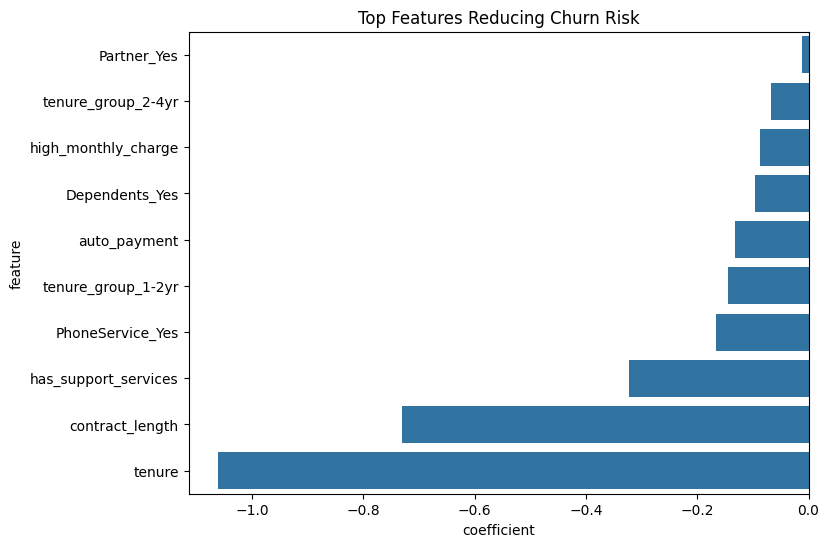

In [9]:
plt.figure(figsize=(8,6))
sns.barplot(
    x="coefficient",
    y="feature",
    data=coef_df.tail(10)
)
plt.title("Top Features Reducing Churn Risk")
plt.show()


Positive coefficients increase the likelihood of churn, while negative coefficients reduce churn risk. Since features were standardized, coefficient magnitude reflects relative importance.

Some tenure-related categorical features show positive coefficients due to multicollinearity with continuous tenure and contract length variables. In this model, overall churn risk is primarily driven by continuous tenure and contract commitment, both of which strongly reduce churn. The categorical tenure coefficients should be interpreted relative to the reference group and in combination with tenure, rather than in isolation.

In [10]:
import shap


c:\Users\abhis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Get scaled features
scaler = model.named_steps["scaler"]
X_scaled = scaler.transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=feature_names)


In [12]:
explainer = shap.LinearExplainer(
    model.named_steps["model"],
    X_scaled_df,
    feature_perturbation="interventional"
)

shap_values = explainer.shap_values(X_scaled_df)


c:\Users\abhis\AppData\Local\Programs\Python\Python311\Lib\site-packages\shap\explainers\_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


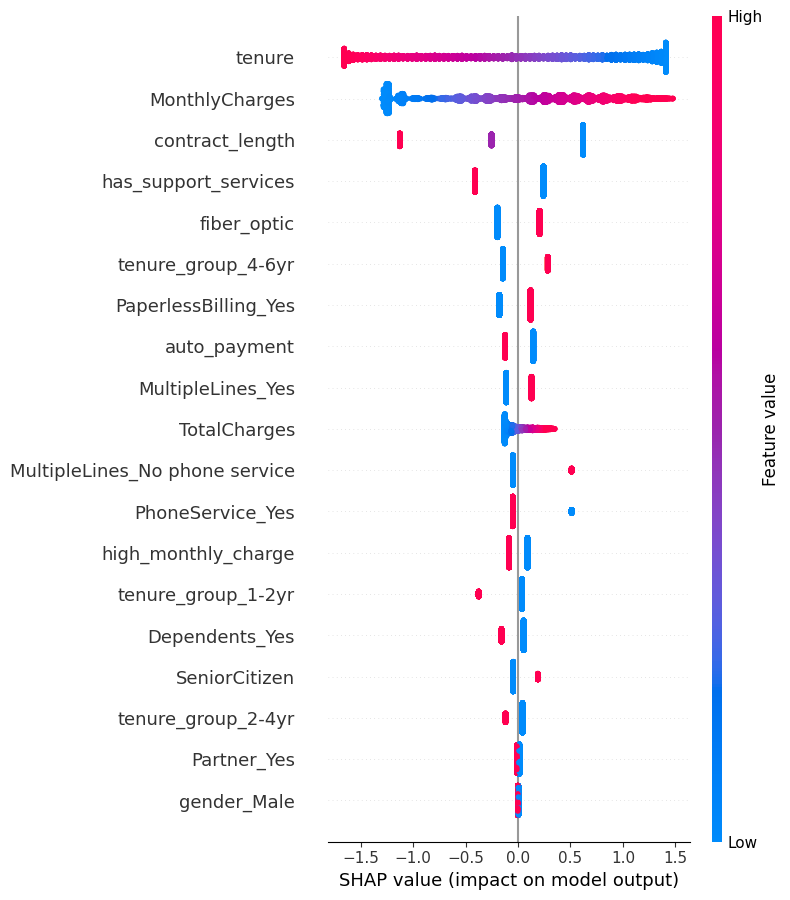

In [13]:
shap.summary_plot(shap_values, X_scaled_df)


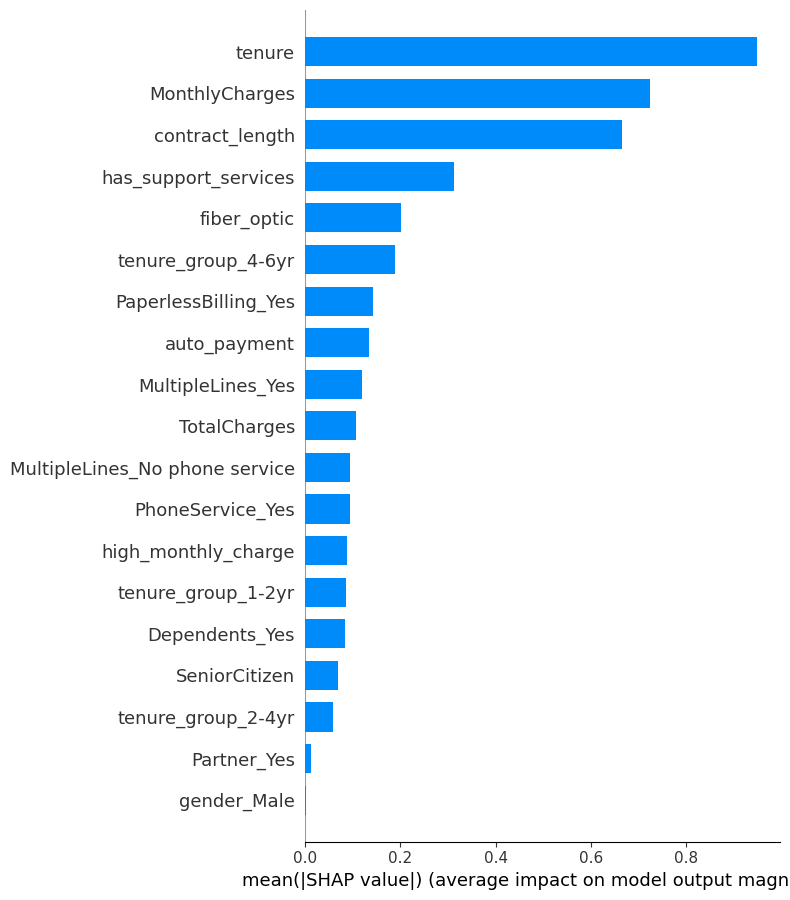

In [14]:
shap.summary_plot(shap_values, X_scaled_df, plot_type="bar")


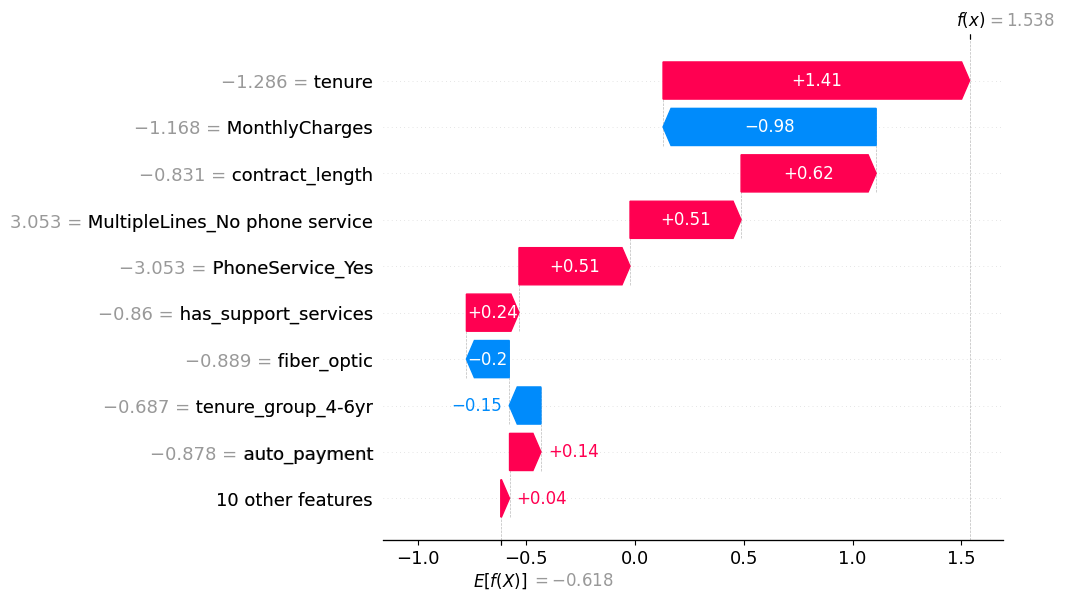

In [25]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[idx],
        base_values=explainer.expected_value,
        data=X_scaled_df.iloc[idx],
        feature_names=X_scaled_df.columns
    ),
    max_display=10
)




SHAP values were used to provide both global and local explanations of the churn model. Global SHAP summary and bar plots highlight tenure, pricing, contract length, and support services as the strongest churn drivers. Local explanations using SHAP waterfall plots demonstrate how individual feature contributions combine to increase or decrease churn risk for a specific customer.